# Imports, classes and methods declaration

In [ ]:
import tensorflow as tf
from keras import layers
from keras import models
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from google.colab import drive
from datetime import datetime
from csv import writer
from csv import DictWriter
import cv2
import numpy as np
import os
import io
import seaborn as sns

drive.mount("/content/gdrive")

# CLASSES
class Dataset:
  """ This class represents the dataset itself """
  
  def __init__ (self, dataset):
    self.info = dataset;
    self.train_images, self.test_images, self.train_labels, self.test_labels = self.get_samples()

  def get_samples(self):
    """ Returns the dataset divided in different areas """

    images = []
    labels = []
    directories = os.listdir(self.info['path'])
    print(len(directories))
    # Reads the images for the training
    for directory in directories:
      samples = len(os.listdir(self.info['path'] + directory))
      for image in os.listdir(self.info['path'] + directory):
        if (samples == 0): break

        image_path = os.path.join(self.info['path'] + directory + '/' + image)

        try:
          # Transforms the image channels to RGB
          current_image = cv2.imread(image_path)
          # Resizes the image
          current_image = cv2.resize(current_image, (Constants.IMAGE_SIZE, Constants.IMAGE_SIZE), interpolation = cv2.INTER_AREA)
          # Set the pixel values between 0 and 1
          current_image = current_image.astype('float32') / 255
        except cv2.error as error:
          print(error)
          continue

        images.append(current_image)

        sample_class_is_covid = (directory == self.info['classes'][0])
        if (sample_class_is_covid): 
          labels.append(1)
        else: 
          labels.append(0)
        
        samples -= 1
    
    # Splits dataset into train and test
    train_images, test_images, train_labels, test_labels = train_test_split(images, labels)

    return np.array(train_images), np.array(test_images), np.array(train_labels), np.array(test_labels)

# METHODS

def runModel(model):
  model.add(layers.Conv2D(
    32, 
    Constants.CONV_WINDOW_SIZE,
    activation=Constants.CONV_ACTIVATION,
    input_shape = Constants.IMAGES_SHAPE,
    padding = Constants.PADDING))
  model.add(layers.MaxPooling2D(Constants.POOLING_SIZE))
  model.add(layers.Conv2D(
    64,
    Constants.CONV_WINDOW_SIZE,
    activation=Constants.CONV_ACTIVATION,
    padding=Constants.PADDING))
  model.add(layers.MaxPooling2D(Constants.POOLING_SIZE))
  model.add(layers.Conv2D(
    128,
    Constants.CONV_WINDOW_SIZE,
    activation=Constants.CONV_ACTIVATION,
    padding=Constants.PADDING))
  model.add(layers.MaxPooling2D(Constants.POOLING_SIZE))
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(loss = Constants.LOSS,
                optimizer = Constants.OPTIMIZER,
                metrics = ['accuracy'])

  # Model train
  model_data = model.fit(dataset.train_images,
          dataset.train_labels,
          batch_size = Constants.BATCH_SIZE,
          epochs = Constants.EPOCHS,
          verbose = 1, 
          validation_split = Constants.VALIDATION_SPLIT)

  # Model results
  test_results = model.evaluate(dataset.test_images, dataset.test_labels, return_dict = True)
  return model_data, test_results

def add_record(date, 
               kernel,
               pooling,
               image_shape,
               loss):
  
  """ Adds a new row to the CSV log file """

  column_names = ['Date',
                  'Dataset',
                  'Kernel size',
                  'Pooling size',
                  'Epochs',
                  'Batch size',
                  'Image shape',
                  'Optimizer',
                  'Loss type',
                  'Test accuracy',
                  'Test Constants.LOSS',
                  'Validation split',
                  'True positives',
                  'False positives',
                  'False negatives',
                  'True negatives',
                  'Precision',
                  'Recall',
                  'Accuracy',
                  'Specificity',
                  'Padding']

  data = {'Date' : date,
          'Dataset' : dataset.info['name'],
          'Kernel size' : kernel,
          'Pooling size' : pooling,
          'Epochs' : Constants.EPOCHS,
          'Batch size' : Constants.BATCH_SIZE,
          'Image shape' : image_shape,
          'Optimizer' : Constants.OPTIMIZER,
          'Loss type' : Constants.LOSS,
          'Test accuracy' : test_results['accuracy'],
          'Test loss' : test_results['loss'],
          'Validation split' : Constants.VALIDATION_SPLIT,
          'True positives' : true_positives,
          'False positives' : false_positives,
          'False negatives' : false_negatives,
          'True negatives' : true_negatives,
          'Precision' : precision,
          'Recall' : recall,
          'Accuracy' : accuracy,
          'Specificity' : specificity,
          'Padding' : Constants.PADDING}
    

  with open('/content/gdrive/MyDrive/ULPGC/TFT/log/radiography/' + dataset.info['name'] +'.csv', 'a', newline='') as write_obj:
      # Creates a writer object from csv module
      dict_writer = DictWriter(write_obj, fieldnames=column_names)
      # Adds dictionary as words in the csv
      dict_writer.writerow(data)   

def get_model_summary_as_string(model):
  stream = io.StringIO()
  model.summary(print_false_negatives=lambda x: stream.write(x + '\n'))
  summary_string = stream.getvalue()
  stream.close()

  return summary_string  

class Constants:
  # DATASETS
  DATASET_2 = {"path" : "/content/gdrive/MyDrive/ULPGC/TFT/data/dataset-2/COVID-CT-master/Images-processed/",
             "name" : "Dataset 2",
             "classes" : ["CT_COVID", "CT_NonCOVID"]}
  
  # IMAGES
  IMAGE_SIZE = 200
  
  # MODEL PARAMETERS
  CONV_WINDOW_SIZE = (5, 5)
  POOLING_SIZE = (2, 2)
  IMAGES_SHAPE = (200, 200, 3)
  EPOCHS = 60
  PADDING = 'valid'
  BATCH_SIZE = 50
  OPTIMIZER = 'sgd'
  LOSS = tf.keras.losses.BinaryCrossentropy()
  VALIDATION_SPLIT = 0.2
  CONV_ACTIVATION = 'relu'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Dataset and train parameters

In [ ]:
dataset = Dataset(Constants.DATASET_2)

2


In [ ]:
# Model information
model_results = [] # empty list for the ROC curve points

# Multiple executions of the same model to get points for the ROC curve
for i in range(10):
  # Model building
  model = models.Sequential()
  model_data, test_results = runModel(model)
  # Model predictions
  model_test_predictions = model.predict(dataset.test_images)
  # ROC curve data
  specificity, sensitivity, threshold = roc_curve(dataset.test_labels, model_test_predictions)
  model_results.append([specificity, sensitivity])

  test_FN(model_test_predictions)

Epoch 1/60
9/9 [==============================] - 1s 107ms/step - loss: 0.7531 - accuracy: 0.5161 - val_loss: 0.6952 - val_accuracy: 0.4732
Epoch 2/60
9/9 [==============================] - 1s 87ms/step - loss: 0.6893 - accuracy: 0.5706 - val_loss: 0.6896 - val_accuracy: 0.5179
Epoch 3/60
9/9 [==============================] - 1s 87ms/step - loss: 0.6869 - accuracy: 0.5403 - val_loss: 0.7069 - val_accuracy: 0.4732
Epoch 4/60
9/9 [==============================] - 1s 87ms/step - loss: 0.6975 - accuracy: 0.5264 - val_loss: 0.7231 - val_accuracy: 0.4732
Epoch 5/60
9/9 [==============================] - 1s 87ms/step - loss: 0.6719 - accuracy: 0.5801 - val_loss: 0.6720 - val_accuracy: 0.6250
Epoch 6/60
9/9 [==============================] - 1s 88ms/step - loss: 0.6688 - accuracy: 0.6275 - val_loss: 0.6996 - val_accuracy: 0.4821
Epoch 7/60
9/9 [==============================] - 1s 86ms/step - loss: 0.6749 - accuracy: 0.5938 - val_loss: 0.6938 - val_accuracy: 0.4911
Epoch 8/60
9/9 [==========

# Train results

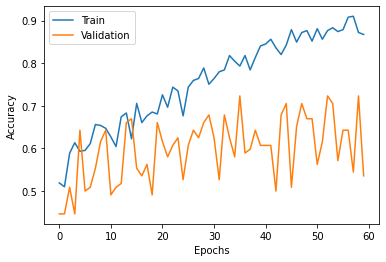

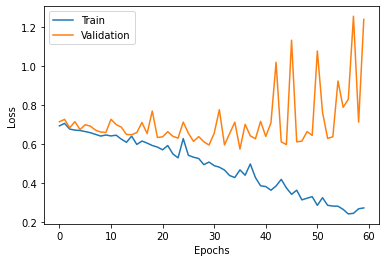

Test accuracy: 0.6505376100540161
Precision:  0.9904761904761905
Recall:  0.574585635359116
Accuracy:  0.5806451612903226
Specificity:  0.8


Text(0.5, 1.0, 'Confusion matrix')

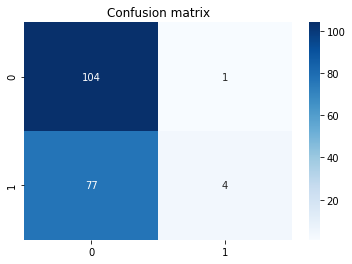

In [ ]:
# ACCURACY AND LOSS
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(model_data.history['accuracy'])
plt.plot(model_data.history['val_accuracy'])
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(model_data.history['loss'])
plt.plot(model_data.history['val_loss'])
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

print('Test accuracy:', test_results['accuracy'])

# CONFUSION MATRIX
# Normalizes the labels. If percentage is 90% or more is has COVID-19, otherwise it has not
model_test_predictions = (model_test_predictions >= 0.9).astype(int)

conf_matrix = confusion_matrix(dataset.test_labels, model_test_predictions)
true_positives = conf_matrix[0][0]
false_positives = conf_matrix[0][1]
false_negatives = conf_matrix[1][0]
true_negatives = conf_matrix[1][1]

# Data got from confusion matrix
precision = (true_positives)/(true_positives+false_positives)
recall = (true_positives)/(true_positives+false_negatives)
accuracy = (true_positives+true_negatives)/(true_positives+true_negatives+false_positives+false_negatives)
specificity = (true_negatives)/(true_negatives+false_positives)

print("Precision: ", precision)
print("Recall: ", recall)
print("Accuracy: ", accuracy)
print("Specificity: ", specificity)

# Plots confusion matrix
conf_display = sns.heatmap(conf_matrix, annot = True, fmt='d', cmap='Blues')
conf_display.set_title("Confusion matrix")

No handles with labels found to put in legend.


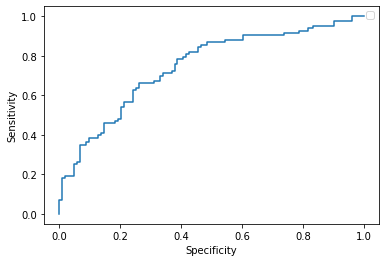

In [ ]:
# ROC CURVE
for point in model_results:
  plt.plot(point[0], point[1])

plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

# Other methods

In [ ]:
add_record(datetime.now(),
           kernel = str(Constants.CONV_WINDOW_SIZE),
           pooling = str(Constants.POOLING_SIZE),
           image_shape = str(Constants.IMAGES_SHAPE),
           Constants.LOSS_type = str(Constants.LOSS))

In [ ]:
plot_model(model, 
           to_file = 'model_plot.png',
           show_shapes = True,
           show_layer_names = True)